In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx

In [2]:
coauthors=pd.read_csv("coauthorship.edgelist", names=["A", "B"], delim_whitespace=True)
coauthors.head()

,A,B
0,2002218453,1999212242
1,2002218453,2032640503
2,2002218453,2475931411
3,2002218453,2477743428
4,2002218453,2504846374


In [53]:
authors=pd.read_csv("author_papers.txt", delimiter="\n", header=None)
authors[["author", "texts"]]=authors[0].str.split(":", 1, expand=True)
authors.drop(0, axis=1, inplace=True)
authors["author"].head()

0    1036332
1    1101850
2    1336878
3    1515524
4    1606427
Name: author, dtype: object

# Analysing graph structure

In [3]:
g = nx.read_edgelist("coauthorship.edgelist",
                     create_using=nx.Graph(), nodetype=int)

# check if the data has been read properly or not.

print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 217801
Number of edges: 1718164
Average degree:  15.7774


Name: 
Type: Graph
Number of nodes: 20
Number of edges: 80
Average degree:   8.0000


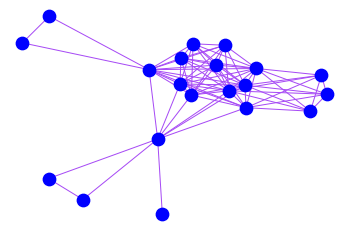

In [4]:
NODE_INITIAL=1797575884
subgraph = g.subgraph(g.neighbors(NODE_INITIAL))
print(nx.info(subgraph))
nx.draw_networkx(
        subgraph,
        node_size=150,
        linewidths=1.5,
        edge_color='#a74bf5',
        edgecolors='b',
        node_color='b',
        with_labels=False
        )
plt.axis('off')
plt.show()

In [47]:
nx.adjacency_matrix(g)

<217801x217801 sparse matrix of type '<class 'numpy.intc'>'
	with 3436328 stored elements in Compressed Sparse Row format>

La table n'est pas symétrique. On préfère travailler systématiquement avec une seule colonne pour un auteur donné, donc on contatene la table coauthors avec son symétrique. Ceci aide pour le code mais pas pour la visualisation.

In [5]:
sym_ca=coauthors[coauthors.columns[::-1]].rename({"A": "B", "B":"A"}, axis=1) #df symétrique
coauthors=pd.concat([coauthors, sym_ca], ignore_index=True)
coauthors.head() 

,A,B
0,2002218453,1999212242
1,2002218453,2032640503
2,2002218453,2475931411
3,2002218453,2477743428
4,2002218453,2504846374


In [6]:
nb_ca=coauthors["A"].value_counts().to_frame()
nb_ca= nb_ca.reset_index().rename(columns={"index":"author", "A":"nb_ca"})

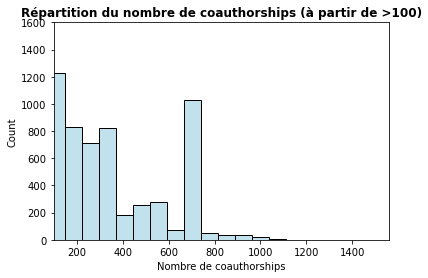

In [45]:
ax=sn.histplot(data=coauthors["A"].value_counts().values, bins=20, color="lightblue")
plt.xlim(left=100)
plt.ylim(top=1600)
plt.xlabel("Nombre de coauthorships")
plt.title("Répartition du nombre de coauthorships (à partir de >100)", fontweight="bold");

## Dummy models
Pour estimer le h-index, on peut utiliser le nombre de coauthorships d'un auteur, et trouver la fonction qui lie cette quantité au h-index via un random forest.

In [8]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv", usecols=[1,2])

n=len(train_df)+len(test_df)
print(f"Data is {len(train_df)/n:.2f}% for training and {len(test_df)/n:.2f}% out of a total of {n} authors.")

Data is 0.80% for training and 0.20% out of a total of 217801 authors.


In [9]:
print(train_df.head())
nb_ca.head()

       author  hindex
0  1964267543     4.0
1  2153592714    13.0
2   217158525     8.0
3  2123103677    11.0
4  2067710487     3.0


,author,nb_ca
0,2165140224,1483
1,2058546385,1398
2,1503156915,1280
3,2566088697,1219
4,426605697,1187


In [31]:
nb_ca.dtypes

author    int64
nb_ca     int64
dtype: object

In [20]:
data_train=nb_ca.merge(train_df, on="author", how="inner")
data_train.describe()

,author,nb_ca,hindex
count,1.742410e+05,174241.000000,174241.000000
mean,2.001807e+09,15.871345,10.087609
std,6.350051e+08,68.750700,12.588073
min,1.515524e+06,1.000000,1.000000
25%,2.021314e+09,2.000000,3.000000
50%,2.134751e+09,4.000000,6.000000
75%,2.288318e+09,8.000000,12.000000
max,2.908499e+09,1483.000000,187.000000


In [21]:
data_train.isnull().values.any()

False

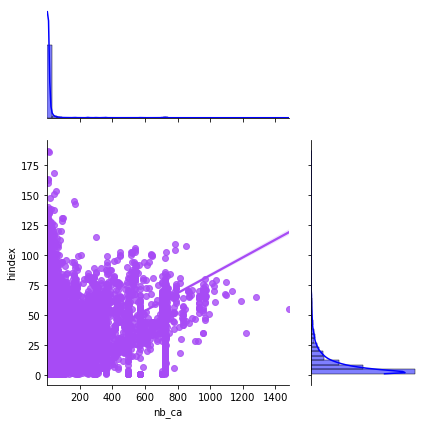

In [12]:
sn.jointplot(data=data_train, x="nb_ca", y="hindex", kind="reg", color="#a74bf5", ratio=2, marginal_kws=dict(bins=50, color="b"))

Hindex et nombre de coauthorships d'un auteur sont donc correlés. Mettons en place directement un modèle simple qui utilise cette correlation, ce qui nous permettra de base de comparaison avec les modèles postérieurs plus complexes.

In [13]:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [29]:
scores = []
mses = []
model=LinearRegression()
kfold = KFold(n_splits=10, shuffle=True)
X,y=data_train["nb_ca"].values.reshape(-1, 1), data_train["hindex"].values.reshape(-1, 1)

for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X[train], y[train])
    score = model.score(X[test], y[test])
    scores.append(score)
    mses.append(mean_squared_error(model.predict(X[test]), y[test]))
print(f"La moyenne des coefficient R^2 des 10 folds est de {np.mean(score):.3f}.")
print(f"La moyenne des MSE des 10 folds est de {np.mean(mses):.2f}.")


La moyenne des coefficient R^2 des 10 folds est de 0.173.
La moyenne des MSE des 10 folds est de 132.31.


Cette prédiction n'est pas très satisfaisante. Il est nécessaire de prendre en place la structure de graph et d'encoder le texte afin d'avoir plus d'informations pour prédire le h index. En fait, l'architecture des GNN permet d'encoder les caractéristiques des noeuds, et notamment le degré de celui ci. 

## Preprocessing


In [16]:
target=data_train["hindex"]
data_train=data_train.drop(columns="hindex")
data_train.describe()

,author,nb_ca
count,1.742410e+05,174241.000000
mean,2.001807e+09,15.871345
std,6.350051e+08,68.750700
min,1.515524e+06,1.000000
25%,2.021314e+09,2.000000
50%,2.134751e+09,4.000000
75%,2.288318e+09,8.000000
max,2.908499e+09,1483.000000


Normalizing target value

## Feature extraction

### Common neighbours